In [2]:
from IPython.display import Markdown, display, HTML
import warnings
warnings.filterwarnings('ignore')

# Dialog Skill Analysis for Watson Assistant

## Introduction
Dialog Skill Analysis for Watson Assistant (WA) is intended for use by chatbot designers, developers & data scientists who would like to experiment with and improve on their existing dialog skill design.  

We assume familiarity with the Watson Assistant product as well as concepts involved in dialog skill design like intent, entities, utterances etc.   

This notebook has been organized into 3 parts based on complexity and expected input from the user.

**Part 1**: Training Data Analysis
- Analyzes the Watson Assistant dialog skill json already created by the user
- Requires the user provide access credentials to an existing WA dialog skill like api_key, workspace_id 

**Part 2**: Model Analysis
- Evaluates the dialog skill against a test set provided by the user
- Requires the user provide a test set for model analysis

**Part 3**: Advanced Analysis
- Analysis related to confidence threshold, term importance etc.
- Requires the user provide a test set for model analysis (same data as part 2)

### Usage
1. Assumes familiarity using a Python Jupyter notebook
2. Assumes a Python 3.6 or greater environment
3. Install dependencies with `pip install -r requirements.txt`  
4. Start jupyter server with `jupyter notebook`
5. Select `skill_analysis.ipynb` to start session

### Alphabetic Contributor List
Watson Assistant Algorithms: Haode Qi, Ladislav Kunc, Ming Tan, Navneet Rao, Panos Karagiannis, Yang Yu

In [3]:
# Standard python libraries
import sys, os
import json
import importlib
from collections import Counter

# External python libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import ibm_watson

# Internal python libraries
sys.path.append("src/main/python")
from utils import skills_util
from highlighting import highlighter
from data_analysis import summary_generator
from data_analysis import divergence_analyzer
from data_analysis import similarity_analyzer
from term_analysis import chi2_analyzer
from term_analysis import keyword_analyzer
from term_analysis import entity_analyzer
from confidence_analysis import confidence_analyzer
from inferencing import inferencer
from experimentation import data_manipulator

[nltk_data] Downloading package stopwords to /home/nrao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nrao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 1 : Training Data Analysis

## Setup: Access Training Data

Please provide access credentials for an existing dialog skill that you would like to analyze.  
Have your API Key & Workspace ID values handy

In [4]:
importlib.reload(skills_util)

# Change Assistant API version if needed
# Find Latest --> https://cloud.ibm.com/docs/services/assistant?topic=assistant-release-notes
API_VERSION = '2019-02-28'

# Change URL based on IBM Cloud datacenter you use   
URL = "https://gateway.watsonplatform.net/assistant/api" # Dallas (Default US South)

#URL = "https://gateway-s.watsonplatform.net/assistant/api" # Dallas Staging
#URL = "https://gateway-wdc.watsonplatform.net/assistant/api" # Washington, DC
#URL = "https://gateway-fra.watsonplatform.net/assistant/api" # Frankfurt
#URL = "https://gateway-syd.watsonplatform.net/assistant/api" # Sydney
#URL = "https://gateway-tok.watsonplatform.net/assistant/api" # Tokyo
#URL = "https://gateway-lon.watsonplatform.net/assistant/api" # London

# By default we only need the IAM API Key & the Workspace ID

# If you run the notebook regularly you can uncomment the two lines below
# & comment out the line after it
#iam_apikey = '###'
#workspace_id = '###'
#Prompt user for credentials
iam_apikey, workspace_id = skills_util.input_credentials()

conversation, workspace = skills_util.retrieve_workspace(iam_apikey=iam_apikey,
                                                         workspace_id=workspace_id,
                                                         url=URL,
                                                         api_version=API_VERSION)

#If you do not have IAM based API Keys
#but have access to a Username, Password & Workspace ID
#You can comment out the two lines above & uncomment the lines below to authenticate
#username = 'apikey'
#password = '###'
#workspace_id = '###'
#conversation, workspace = skills_util.retrieve_workspace(username=username,
#                                                         password=password,
#                                                         workspace_id=workspace_id,
#                                                         url=URL,
#                                                         api_version=API_VERSION)

Please enter apikey: ········
Please enter workspace-id: ········


In [5]:
# Extract user workspace
workspace_data, workspace_vocabulary = skills_util.extract_workspace_data(workspace)
entity_dict = conversation.list_entities(workspace_id).get_result()
entities_list = [item['entity'] for item in entity_dict['entities']]
# Create workspace data frame
workspace_pd = pd.DataFrame(workspace_data)

display(Markdown("### Sample of Utterances & Intents"))
display(HTML(workspace_pd.sample(n = len(workspace_pd) if len(workspace_pd)<10 else 10)
             .to_html(index=False)))
if entities_list:
    display(Markdown("### Sample of Entities"))
    display(HTML(pd.DataFrame({"Entity":entities_list})
                 .sample(n = len(entities_list) if len(entities_list)<10 else 10)
                 .to_html(index=False)))

### Sample of Utterances & Intents

utterance,intent
Connect me to a live operator please.,General_Connect_to_Agent
how late are you open tonight,Customer_Care_Store_Hours
Need help from human,General_Connect_to_Agent
What time does the central manchester store sh...,Customer_Care_Store_Hours
how do i get to your place,Customer_Care_Store_Location
Does the store in the city center opens till 8...,Customer_Care_Store_Hours
how do i get to your business,Customer_Care_Store_Location
will you open on christmas,Customer_Care_Store_Hours
hi,General_Greetings
How early do you open?,Customer_Care_Store_Hours


### Sample of Entities

Entity
holiday
sys-number
specialist
landmark
phone
sys-time
reply
sys-date
zip_code


## 1.1 Process Dialog Skill Training Data

We generate summary statistics related to the given skill & workspace

In [6]:
importlib.reload(summary_generator)
summary_generator.generate_summary_statistics(workspace_data, entities_list)

### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,184
2,Unique Intents,9
3,Average User Examples per Intent,20
4,Standard Deviation from Average,14
5,Total Number of Entities,9



## 1.2 Data Distribution Analysis

### Class Imbalance Analysis

We analyze whether the dataset contains class imbalance by checking whether the largest intent contains less than double the number of user examples contained in the smallest intent. Presense of imbalance does not necessarily indicate an issue, please review the actions section below

In [7]:
importlib.reload(summary_generator)
class_imb_flag = summary_generator.class_imbalance_analysis(workspace_pd)

### <font style='color:rgb(165, 34, 34);'> Class Imbalance Detected         </font>

- Data could be potentially biased towards intents with more user         examples

- E.g. Intent < General_Connect_to_Agent > has < 47 > user examples while intent < Help > has         just < 6 > user examples 

### Distribution of User Examples by Intent
We display the distribution of intents vs the number of examples per intent (sorted by the number of examples per intent) below. Ideally we should not have large variations in terms of number of user examples for various intents. 

## <p style="text-align: center;">Sorted Distribution of User Examples                      per Intent</p>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


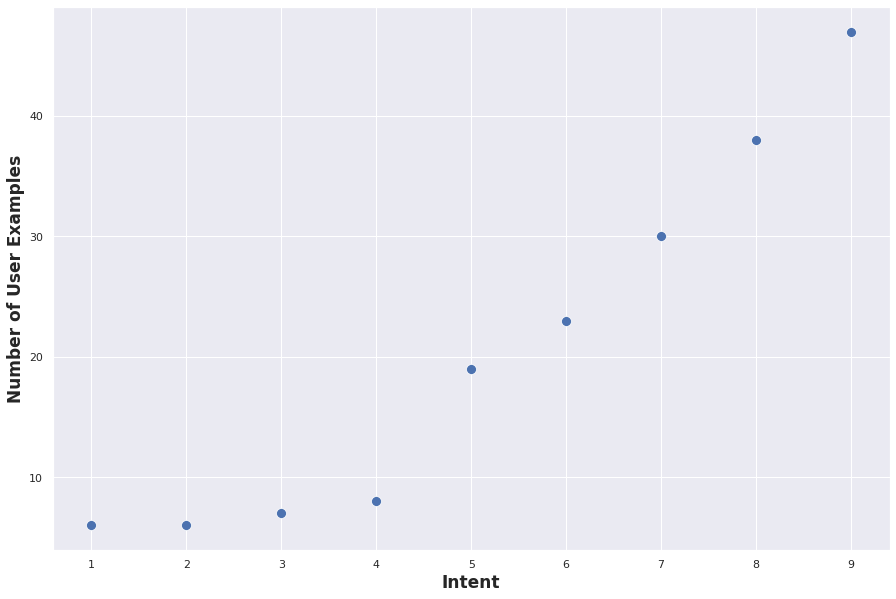

In [8]:
importlib.reload(summary_generator)
summary_generator.scatter_plot_intent_dist(workspace_pd)

In [9]:
importlib.reload(summary_generator)
summary_generator.show_user_examples_per_intent(workspace_data)

### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,Help,6
2,Goodbye,6
3,Cancel,7
4,Thanks,8
5,Customer_Care_Appointments,19
6,Customer_Care_Store_Location,23
7,General_Greetings,30
8,Customer_Care_Store_Hours,38
9,General_Connect_to_Agent,47


### Actions for Class Imbalance

Class imbalance will not always lead to lower accuracy. All intents (classes) thus need not have the same number of examples.

1. For intents like `updateBankAccount` and `addNewAccountHolder` where the semantics difference between them is more subtle, the number of examples per intent needs to be somewhat balanced else the classifier might favor the intent with the higher number of examples.
2. For intents like `greetings` that are semantically distinct from other intents like `updateBankAccount`, it may be okay for it to have fewer examples per intent and still be easy for the intent detector to classify.

If during testing it seems like intent classification accuracy is lower than expected, we advise you to re-examine this distribution analysis.  

With regard to sorted distribution of examples per intent, if the sorted number of user examples varies a lot across different intents, it can be a potential source of bias for intent detection. Large imbalances in general should be avoided. This can potentially lead to lower accuracy. If your graph displays this characteristic, this might be a source of error.

For further guidance on adding more examples to help balance out your distribution, please refer to 
https://cloud.ibm.com/docs/services/assistant?topic=assistant-intent-recommendations#intent-recommendations-get-example-recommendations

## 1.3 Term Analysis - Correlation Analysis

### Retrieve the most correlated unigrams and bigrams for each intent

We perform a chi square significance test using count features to determine the terms that are most correlated with each intent in the dataset. 

A `unigram` is a single word, while a `bigram` is two consecutive words from within the training data. E.g. If you have a sentence like `Thank you for your service`, each of the words in the sentence are considered unigrams while terms like `Thank you`, `your service` are considered bigrams.

If you see terms like `hi`, `hello` correlated with a `greeting` intent that would be reasonable. But if you see terms like `table`, `chair` correlated with the `greeting` intent that would be anomalous. A scan of the most correlated unigrams & bigrams for each intent can help you spot potential anomalies within your training data.

**Note**: We ignore the following common words from consideration `an, a, in, on, be, or, of, a, and, can, is, to, the, i`

In [10]:
importlib.reload(chi2_analyzer)
unigram_intent_dict, bigram_intent_dict = chi2_analyzer.get_chi2_analysis(workspace_pd)

## Chi-squared Analysis

,Intent,Correlated Unigrams,Correlated Bigrams
1,General_Connect_to_Agent,"want, please, talk, speak, agent","are you, connect me, speak human, want speak, want talk"
2,Customer_Care_Store_Hours,"hours, time, what, are, open","how late, do you, what time, what are, you open"
3,General_Greetings,"been, going, hello, good, hey","hey how, have you, hey there, you been, how are"
4,Customer_Care_Store_Location,"give, directions, location, find, where","do get, me directions, get your, where are, how do"
5,Customer_Care_Appointments,"next, visit, face, make, appointment","face visit, d like, face face, like make, make appointment"
6,Thanks,"many, appreciated, much, thank, thanks","many thanks, appreciate it, much appreciated, you very, thank you"
7,Cancel,"forget, changed, cancel, mind, anymore","forget it, changed my, cancel that, cancel request, anymore anymore"
8,Goodbye,"see, arrivederci, ciao, ya, bye","good bye, see ya, so long"
9,Help,"me, assist, assistance, decide, help","you assist, me decide, need assistance, you help, help me"


### Actions for Anomalous Correlations

If you identify unusual / anomalous correlated terms like: numbers, names etc., which should not be correlated with an intent please read the following:
  
- **Case 1** : If you see names appearing amongst correlated unigrams or bigrams, add more variation of names so no specific names will be correlated  
- **Case 2** : If you see specific numbers like 1234 amongst correlated unigrams or bigrams and are not helpful to the use case, remove or mask these numbers from the examples
- **Case 3** : If you see terms which should never be correlated to that specific intent, consider adding or removing terms/examples so that domain specific terms are correlated with the correct intent

## 1.4 Term Analysis - Heat Map

A heatmap of terms is a method using which we can visualize which terms or words are frequently occuring within each intent. Rows are the terms and columns are the intents. 

By default we show only the top 30 intents with the highest number of user examples in the analysis. This number can be changed if needed.

## <p style="text-align: center;"> Token Frequency per Intent </p>

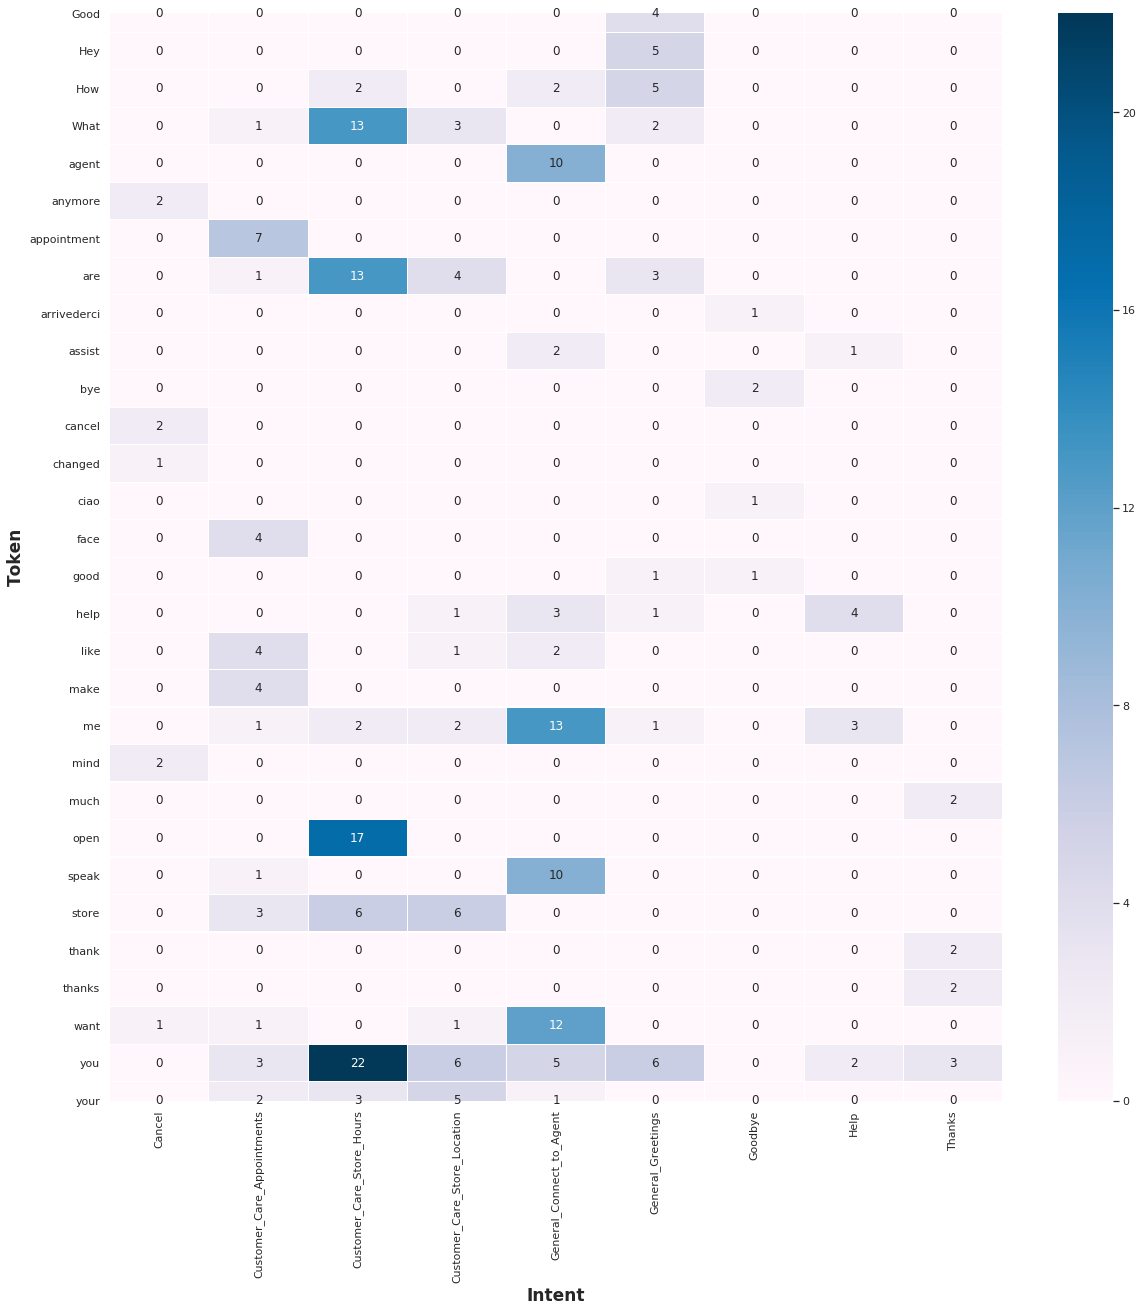

In [11]:
importlib.reload(keyword_analyzer)

INTENTS_TO_DISPLAY = 30  # Total number of intents for display
MAX_TERMS_DISPLAY = 30  # Total number of terms to display

intent_list = []
keyword_analyzer.seaborn_heatmap(workspace_pd, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Term Analysis for Custom Intent List

If you wish to see term analysis for specific intents, feel free to add those intents to the intent list. This shall generate a custom term heatmap. By default we show the top 30 tokens, but this can be changed if needed

In [12]:
importlib.reload(keyword_analyzer)
# intent_list = ['intent1','intent2','intent3'] 
intent_list = [] 


MAX_TERMS_DISPLAY = 20  # Total number of terms to display

if intent_list: 
    keyword_analyzer.seaborn_heatmap(workspace_pd, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Actions for Anomalous Terms in Heat Map

If you notice any terms or words which should not be frequently present within an intent, consider modifying examples in that intent

## 1.5 Ambiguity in Training Data
### Uncover possibly ambiguous terms based on feature correlation
Based on the chi-square analysis above, we generate intent pairs whose correlated unigrams and bigrams overlap.
This allows us to get a glimpse of which unigrams or bigrams might cause potential confusion in intent detection.

### A. Top Intent Pairs whose correlated unigrams overlap

In [13]:
importlib.reload(chi2_analyzer)
ambiguous_unigram_df = chi2_analyzer.get_confusing_key_terms(unigram_intent_dict)

There is no ambiguity based on top 5 key terms in chi2 analysis

### B. Top Intent Pairs whose correlated bigrams overlap

In [14]:
importlib.reload(chi2_analyzer)
ambiguous_bigram_df = chi2_analyzer.get_confusing_key_terms(bigram_intent_dict)

There is no ambiguity based on top 5 key terms in chi2 analysis

### C. Overlap Checker for Specific Intents

In [15]:
# Add specific intent or intent pairs for which you would like to see overlap
importlib.reload(chi2_analyzer)
intent1 = 'Goodbye'
intent2 = ''
chi2_analyzer.chi2_overlap_check(ambiguous_unigram_df,ambiguous_bigram_df,intent1,intent2)

### Uncover ambiguous utterances across intents
The following analysis shows user examples that are similar but fall under different Intents.  

In [16]:
importlib.reload(similarity_analyzer)
similar_utterance_diff_intent_pd = similarity_analyzer.ambiguous_examples_analysis(workspace_pd)

### There are no similar utterances within different Intent

## Actions for Ambiguity in Training Data

**Ambiguous Intent Pairs**  
If you see terms which are correlated with more than 1 intent, please review if this seems anomalous based on the use case for that intent. If it seems reasonable, it may not be an issue.  

**Ambiguous Utterances across intents** 
1. **Duplicates Utterances**: For duplicate or almost identical utterances, remove those that seem unnecesssary
2. **Similar Utterances**: For similar utterances please review the use case for those intents and make sure that they are not accidental additions caused by human error in creating the training data  

Reference for more information on entities: https://cloud.ibm.com/docs/services/assistant/services/assistant?topic=assistant-entities

For more in-depth analysis related to possible conflicts in your training data across intents, try the conflict detection feature in Watson Assistant https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts

# Part 2: Model Analysis

Analyze your existing Watson Assistant Dialog Skill with the help of a test set.

## Setup: Upload Test Data
Please upload a test set in csv/tsv format. Each line in the file should have only `User_Input<tab>Intent`  

An example would be
```
hello how are you<tab>Greeting  
I would like to talk to a human<tab>AgentHandoff  
```

Modify the separator used if you want to use data in csv format rather than tsv

In [17]:
importlib.reload(skills_util)

#Separator: Use '\t' for tab separated data, ',' for comma separated data
separator = '\t'

test_set_path = 'test_set.tsv'
test_df = skills_util.process_test_set(test_set_path, separator)

display(Markdown("### Random Test Sample"))
display(HTML(test_df.sample(n=10).to_html(index=False)))

### Random Test Sample

utterance,intent
What is your IQ,SYSTEM_OUT_OF_DOMAIN
Hey twin,General_Greetings
I dont think I want to do that,Cancel
I prefer a face to face visit,Customer_Care_Appointments
Is the store going to be open tomorrow,Customer_Care_Store_Hours
ciao,Goodbye
When can I meet with one of your employees at ...,Customer_Care_Appointments
can you help,Help
I want to know about a store,Customer_Care_Store_Location
how early do you open on Saturdays,Customer_Care_Store_Hours


## Evaluate Test Data
These steps can take time if you have a large test set  

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan 

In [18]:
# Maximum of 5 threads for faster inference
THREAD_NUM = 5
full_results = inferencer.inference(conversation,
                                    workspace_id,
                                    test_df,
                                    max_retries=10,
                                    max_thread=THREAD_NUM, 
                                    verbose=False)

Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-5
Exiting Thread-3
Exiting Thread-1
Exiting Thread-2
Exiting Thread-4
--- Total time: 6.7117249965667725 seconds ---


## 2.1 Model Analysis

### Test Data Overview

In [19]:
importlib.reload(summary_generator)
summary_generator.generate_summary_statistics(test_df)
summary_generator.show_user_examples_per_intent(test_df)

### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,53
2,Unique Intents,10
3,Average User Examples per Intent,5
4,Standard Deviation from Average,3
5,Total Number of Entities,0


### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,Help,2
2,Thanks,2
3,Cancel,3
4,Goodbye,3
5,Customer_Care_Store_Location,5
6,Customer_Care_Appointments,5
7,SYSTEM_OUT_OF_DOMAIN,7
8,General_Greetings,7
9,Customer_Care_Store_Hours,9
10,General_Connect_to_Agent,10


### Compare Test Data & Training Data

Ideally the Test and Training Data distributions should be similar. The following metrics can help identify gaps between Test Set and Training Set:

**1.**  The distribution of User Examples per Intent for the Test Data should be comparable to the Training Data   
**2.**  Average length of User Examples for Test and Training Data should be comparable  
**3.**  The vocabulary and phrasing of utterances in the Test Data should be comparable to the Training Data

If your test data comprises of examples labelled from your logs, and the training data comprises of examples created by human subject matter experts, there may be discrepancies between what the virtual assistant designers thought the end users would type and the way they actually type in production. Thus if you find discrepancies in this section, you might want to consider changing your design to more closely resemble the way end users use your system.

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan

In [20]:
importlib.reload(divergence_analyzer)
divergence_analyzer.analyze_train_test_diff(workspace_pd, test_df, full_results)

## Test Data Evaluation

,Intent,% of Train,% of Test,Absolute Difference %,Train Examples,Test Examples,Test Precision %,Test Recall %,Test F1 %
0,General_Connect_to_Agent,25.54,18.87,6.68,47,10,83.33,100,90.91
1,Customer_Care_Store_Hours,20.65,16.98,3.67,38,9,81.82,100,90
2,General_Greetings,16.3,13.21,3.1,30,7,77.78,100,87.5
3,Customer_Care_Store_Location,12.5,9.43,3.07,23,5,71.43,100,83.33
7,Goodbye,3.26,5.66,2.4,6,3,100,66.67,80
6,Cancel,3.8,5.66,1.86,7,3,100,66.67,80
4,Customer_Care_Appointments,10.33,9.43,0.89,19,5,100,100,100
5,Thanks,4.35,3.77,0.57,8,2,100,100,100
8,Help,3.26,3.77,0.51,6,2,66.67,100,80


Distribution Mismatch Color Code

<font color = 'red'>      Red - Severe </font>

<font color = 'blue'>     Blue - Caution </font>

<font color = 'green'>    Green - Good </font>

### Data Distribution Divergence Test vs Train         <font color='blue'>9.0%</font>

**Note** Metric used is Jensen Shannon Distance

### Test Data Example Length

Average length of user examples is comparable

### Vocabulary Size Test vs Train

,Train Vocabulary Size,Test Vocabulary Size,% Test Set Vocabulary not found in Train
1,264,142,14.08


### Determine Overall Accuracy on Test Set

In [21]:
importlib.reload(inferencer)
results = full_results[['correct_intent', 'top_confidence','top_intent','utterance']]
accuracy = inferencer.calculate_accuracy(results)
display(Markdown("### Accuracy on Test Data: {} %".format(accuracy)))

### Accuracy on Test Data: 83.02 %

### Error Analysis

This section gives the user an overview of the errors made by the intent classifier on the test set  

**Note** `System Out of Domain` labels are assigned to user examples which get classified with confidence scores less than 0.2 as Watson Assistant would consider them to be irrelevant

In [22]:
importlib.reload(inferencer)
wrongs_df = inferencer.calculate_mistakes(results)
display(Markdown("### Intent Detection Mistakes"))
display(Markdown("Number of Test Errors: {}".format(len(wrongs_df))))

with pd.option_context('max_colwidth', 250):
    if not wrongs_df.empty:
        display(wrongs_df)

### Intent Detection Mistakes

Number of Test Errors: 9

,correct_intent,top_confidence,top_intent,utterance
Test Example Index,,,,
42,Goodbye,0.717852,General_Greetings,see you tomorrow
44,Cancel,0.478762,General_Connect_to_Agent,I dont think I want to do that
46,SYSTEM_OUT_OF_DOMAIN,0.491598,General_Greetings,Can you tell me a good joke
47,SYSTEM_OUT_OF_DOMAIN,0.404056,Customer_Care_Store_Hours,What is your IQ
48,SYSTEM_OUT_OF_DOMAIN,0.344223,Customer_Care_Store_Hours,"Luke, I am your father"
49,SYSTEM_OUT_OF_DOMAIN,0.639739,Customer_Care_Store_Location,Where did Betty buy her butter?
50,SYSTEM_OUT_OF_DOMAIN,0.547800,General_Connect_to_Agent,How many engineers does it take to change a lightbulb?
51,SYSTEM_OUT_OF_DOMAIN,0.623351,Help,Can you help me change my account password?
52,SYSTEM_OUT_OF_DOMAIN,0.939839,Customer_Care_Store_Location,What is a way to change my account address?


## Part 3: Advanced Analysis

## 3.1 Analysis using Confidence Thresholds

In this phase of the analysis, we illustrate how a confidence threshold which is used to determine what is considered irrelevant or out of domain can be used for analysis 

### Threshold Metrics

We calculate metrics for responses where the top intent has a confidence above the         threshold specified on the x-axis.  

We consider examples which are within the scope of the chatbot's problem formulation as          on topic or in domain and those examples which are outside the scope of the problem to be          out of domain or irrelevant

#### 1) Thresholded On Topic Accuracy (TOA)

x-axis: Confidence threshold used || y-axis: Intent Detection Accuracy for On Topic utterances

#### 2)  Bot Coverage %

x-axis: Confidence threshold used || y-axis: Fraction of All utterances above the threshold

#### 3) False Acceptance Rate for Out of Domain Examples (FAR)

x-axis: Confidence threshold used || y-axis: Fraction of Out of Domain utterances falsely considered on topic

#### Note: Default acceptance threshold for Watson Assistant is set at 0.2.        Utterances with top intent confidence < 0.2 will be considered irrelevant

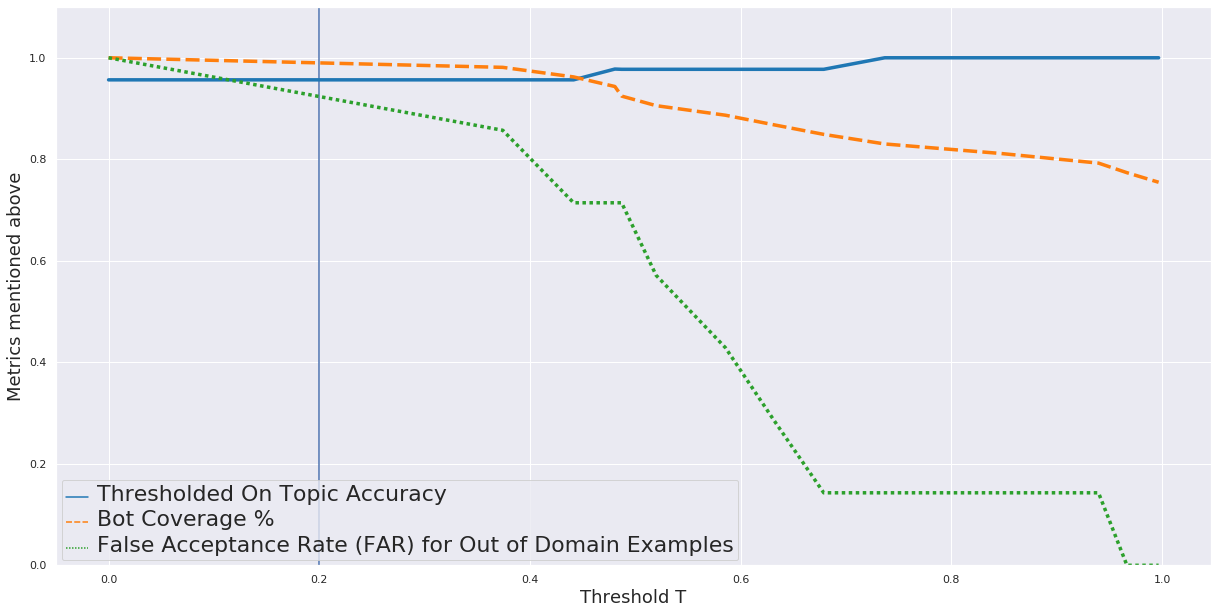

In [23]:
importlib.reload(confidence_analyzer)
analysis_df= confidence_analyzer.analysis(results,None)

## Analysis Interpretation @ Confidence Level T 

If a certain confidence threshold T is selected then 
1. The on topic accuracy for test examples which cross the threshold is ***TOA***
2. Percentage of total test examples which returned confidences higher than the threshold measured as ***Bot Coverage %***
3. If out of domain examples exist, we falsely accept out of domain examples as on topic examples at a rate measured by ***FAR***

In [24]:
analysis_df.index = np.arange(1, len(analysis_df)+1)
display(analysis_df)

,Threshold (T),Ontopic Accuracy (TOA),Bot Coverage %,Bot Coverage Counts,False Acceptance Rate (FAR)
1,0.0,95.652174,100.000000,53 / 53,100.000000
2,0.1,95.652174,100.000000,53 / 53,100.000000
3,0.2,95.652174,100.000000,53 / 53,100.000000
4,0.3,95.652174,100.000000,53 / 53,100.000000
5,0.4,95.652174,98.113208,52 / 53,85.714286
6,0.5,97.727273,92.452830,49 / 53,71.428571
7,0.6,97.727273,88.679245,47 / 53,42.857143
8,0.7,97.727273,84.905660,45 / 53,14.285714
9,0.8,100.000000,83.018868,44 / 53,14.285714
10,0.9,100.000000,81.132075,43 / 53,14.285714


## Threshold Selection

By selecting a higher threshold we can potentially bias our systems towards being more accurate in terms of determining whether an utterance is on topic or out of domain. The default confidence threshold for Watson Assistance is 0.2  

**Effect on Accuracy**: When we select a higher threshold T, this can result in higher accuracy (TOA) on those thresholded examples since we are looking at utterances that the intent detector is more confident on.

**Effect on Bot Coverage %**: But when we select a higher threshold T, this can also result in less examples being responded to by the virtual assistant.

**Deflection to Human Agent**: In the scenarios where the virtual assistant is setup to hand off to a human agent when its less confident, having a higher threshold T can:  

1. Improve end user experience when interacting with a virtual assistant, as it is continuing interaction only when its highly confident
2. But this can result in higher costs to the customer as this can result in more deflections to the human agents 
3. There is thus a trade-off and a threshold needs to be decided on a per customer basis

## Threshold Selection on Individual Intents
This section allows the examination of thresholds on specific intents.

- Use INTENT_LIST = [] to get analysis which averages across all intents
- Use INTENT_LIST = ['intent1', 'intent2'] to examine specific intents and threshold analysis on these intents
- Use INTENT_LIST = ['ALL_INTENTS'] to examine all intents and threshold analysis for each
- Use INTENT_LIST = [MOST_FREQUENT_INTENT] to get analysis on the intent with the most test examples (DEFAULT)

**False Acceptance Rate (FAR) for specific intents**  
When we calculate FAR across all intents (as in previous section) we calculate fraction of out of domain examples falsely considered on topic. When we calculate FAR for specific intents we calculate the fraction of examples which were falsely predicted to be that specific intent.

In [25]:
importlib.reload(confidence_analyzer)

# Calculate intent with most test examples
for label in list(test_df['intent'].value_counts().index):
    if label != skills_util.OFFTOPIC_LABEL:
        MOST_FREQUENT_INTENT = label 
        break
        
# Specify intents of interest for analysis      
INTENT_LIST = [MOST_FREQUENT_INTENT]  

analysis_df_list = confidence_analyzer.analysis(results, INTENT_LIST)

### Threshold Analysis for Intent: General_Connect_to_Agent

Out of Domain examples fewer than **5** thus             no False Acceptance Rate (FAR) calculated

,Threshold (T),Ontopic Accuracy (TOA),Bot Coverage %,Bot Coverage Counts
1,0.0,100.0,100.000000,12 / 12
2,0.1,100.0,100.000000,12 / 12
3,0.2,100.0,100.000000,12 / 12
4,0.3,100.0,100.000000,12 / 12
5,0.4,100.0,100.000000,12 / 12
6,0.5,100.0,100.000000,12 / 12
7,0.6,100.0,91.666667,11 / 12
8,0.7,100.0,91.666667,11 / 12
9,0.8,100.0,83.333333,10 / 12
10,0.9,100.0,83.333333,10 / 12


## 3.2 Term Importance Highlighting

This intent can be ground-truth or an incorrect predicted intent. It provides term level insights on which terms the classifier thought were important in relation to that specific intent.

Even if the system predicts an intent correctly, the terms which the intent classifier though were important may not be as expected by human insight. Human insight might suggest that the intent classifier is focusing on the wrong terms.  

The score of each term in the following highlighted images can be viewed as importance factor of that term for that specific intent. The larger the score, the more important the term.

We can get the highlighted images for either wrongly-predicted utterances or utterances where the classifier returned a low confidence.   

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan

### Identified 1 problematic utterances 

Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-2
Exiting Thread-5
Exiting Thread-1
Exiting Thread-3
Exiting Thread-4
--- Total time: 0.6811437606811523 seconds ---


1 examples are shown below:

,Characteristic,Value
1,Test Set Index,0
2,Utterance,Where is the closest agent?
3,Actual Intent,General_Connect_to_Agent
4,Predicted Intent,General_Connect_to_Agent
5,Confidence,1


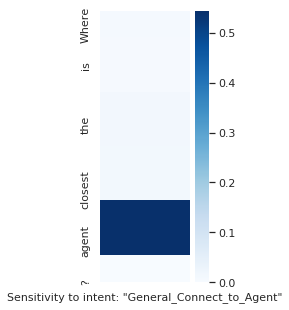

In [26]:
importlib.reload(highlighter)

# Pick an example from section 1 which was misclassified
# Add the example and correct intent for the example
utterance = "Where is the closest agent?"  # input example
intent = "General_Connect_to_Agent"  # input an intent in your workspace which you are interested in.


inference_results = inferencer.inference(conversation=conversation, 
                                    workspace_id=workspace_id, 
                                    test_data=pd.DataFrame({'utterance':[utterance], 
                                                            'intent':[intent]}), 
                                    max_retries = 10, 
                                    max_thread = 1, 
                                    verbose = False)

highlighter.get_highlights_in_batch_multi_thread(conversation, 
                                                 workspace_id,
                                                 inference_results, 
                                                 None,
                                                 1,
                                                 1)

In the section below we analyze your test results and produce highlighting for the top 25 problematic utterances which were either mistakes or had confidences below the threshold that was set.    

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan

### Identified 9 problematic utterances 

Starting Thread-1
Starting Thread-2
Starting Thread-3Starting Thread-4
Starting Thread-5

Exiting Thread-4
Exiting Thread-1
Exiting Thread-2
Exiting Thread-3
Exiting Thread-5
--- Total time: 7.141055107116699 seconds ---


25 examples are shown below:

,Characteristic,Value
1,Test Set Index,52
2,Utterance,What is a way to change my account address?
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.939839


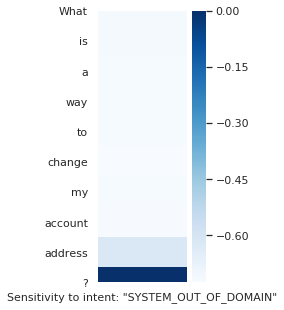

,Characteristic,Value
1,Test Set Index,42
2,Utterance,see you tomorrow
3,Actual Intent,Goodbye
4,Predicted Intent,General_Greetings
5,Confidence,0.717852


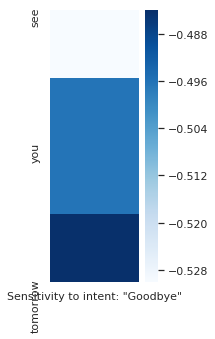

,Characteristic,Value
1,Test Set Index,44
2,Utterance,I dont think I want to do that
3,Actual Intent,Cancel
4,Predicted Intent,General_Connect_to_Agent
5,Confidence,0.478762


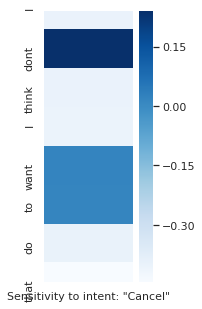

,Characteristic,Value
1,Test Set Index,49
2,Utterance,Where did Betty buy her butter?
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.639739


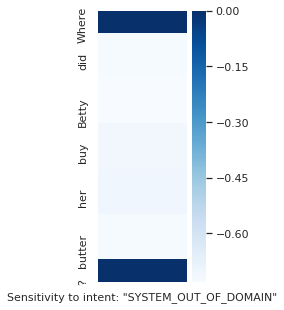

,Characteristic,Value
1,Test Set Index,51
2,Utterance,Can you help me change my account password?
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Help
5,Confidence,0.623351


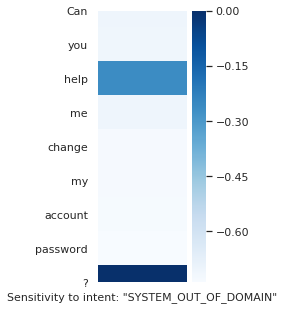

,Characteristic,Value
1,Test Set Index,50
2,Utterance,How many engineers does it take to change a lightbulb?
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,General_Connect_to_Agent
5,Confidence,0.5478


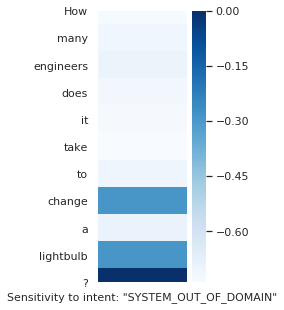

,Characteristic,Value
1,Test Set Index,46
2,Utterance,Can you tell me a good joke
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,General_Greetings
5,Confidence,0.491598


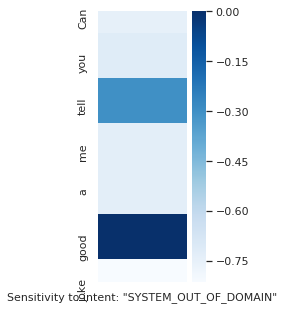

,Characteristic,Value
1,Test Set Index,47
2,Utterance,What is your IQ
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Hours
5,Confidence,0.404056


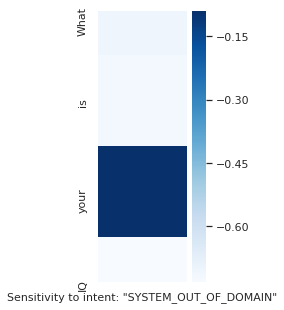

,Characteristic,Value
1,Test Set Index,48
2,Utterance,"Luke, I am your father"
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Hours
5,Confidence,0.344223


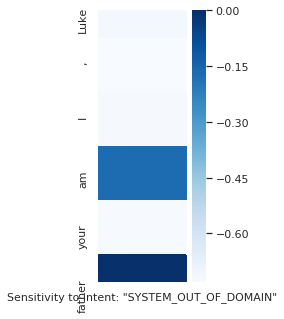

In [27]:
importlib.reload(highlighter)

# The output folder for generated images
# Note modify this if you want the generated images to be stored in a different directory

highlighting_output_folder = './highlighting_images/'
if not os.path.exists(highlighting_output_folder):
    os.mkdir(highlighting_output_folder)

# The threshold the prediction needs to achieve below which  
# it will be considered as `out of domain` or `offtopic` utterances. 
threshold = 0.2

# Maximum number of test set examples whose highlighting analysis will be conducted
K=25
highlighter.get_highlights_in_batch_multi_thread(conversation, 
                                                 workspace_id,full_results, 
                                                 highlighting_output_folder,
                                                 threshold,
                                                 K)

## 3.3 Abnormal Confidence Analysis
Every test utterance is classified as a specific intent with a specific confidence by the WA intent classifier. It is expected that model would be confident when correctly predicting examples and not highly confident when incorrectly predicting examples. 

But often this is not true. This may suggest there are anomalies in the design. Examples that are predicted correctly with low confidence and the examples that are predicted incorrectly with high confidence are thus cases which need to be reviewed.

In [28]:
importlib.reload(confidence_analyzer)
correct_thresh, wrong_thresh = 0.3, 0.7
correct_with_low_conf_list, incorrect_with_high_conf_list = confidence_analyzer.abnormal_conf(
    full_results, correct_thresh, wrong_thresh)

In [29]:
if len(correct_with_low_conf_list) > 0:
    display(Markdown("#### Examples correctedly predicted with low confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(correct_with_low_conf_list.to_html(index=False)))

In [30]:
if len(incorrect_with_high_conf_list) > 0:
    display(Markdown("#### Examples incorrectedly predicted with high confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(incorrect_with_high_conf_list.to_html(index=False)))

#### Examples incorrectedly predicted with high confidence

correct_intent,utterance,top1_prediction,top2_prediction,top3_prediction
Goodbye,see you tomorrow,General_Greetings (0.718),Customer_Care_Appointments (0.303),Goodbye (0.269)


## Actions for abnormal confidence examples

If there are examples which are getting classified incorrectly with high confidence for specific intents, it may indicate an issue in the design of those specific intents as the user examples provided for that intent may be overlapping with the design of other intents.

If intent A seems to always get misclassified as intent B with high confidence or gets correctly predicted with low confidence, please consider using intent conflict detection https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts

Also consider whether those two intents need to be two separate intents or whether they need to be merged. If they can't be merged, then consider adding more user examples which distinguish intent A specifically from intent B.

## 3.4 Analysis using Correlated Entities per Intent

We perform a chi square significance test for entities as we did for unigrams and bigrams in the previous section. For each utterance in the training data, this analysis will call the mesage api for entity detection on each utterance and find the most correlated entities for each intent

<font color=red>**Note**</font>: You will be charged for calls made from this notebook  based on your WA plan 

In [31]:
importlib.reload(entity_analyzer)
importlib.reload(inferencer)
if entities_list:
    THREAD_NUM = 5# we allow a maximum of 5 threads for faster inference
    train_full_results = inferencer.inference(conversation,
                                              workspace_id,
                                              workspace_pd,
                                              max_retries=10, 
                                              max_thread=THREAD_NUM,
                                              verbose=False)
    entity_label_correlation_df = entity_analyzer.entity_label_correlation_analysis(
        train_full_results, entities_list)
    with pd.option_context('display.max_colwidth', 200):
        entity_label_correlation_df.index = np.arange(1, len(entity_label_correlation_df) + 1)
        display(entity_label_correlation_df)
else:
    display(Markdown("### Target workspace has no entities."))

Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-5
Exiting Thread-1
Exiting Thread-3
Exiting Thread-2
Exiting Thread-4
--- Total time: 23.475440502166748 seconds ---


,Intent,Correlated Entities
1,General_Connect_to_Agent,"sys-date, reply"
2,Customer_Care_Appointments,sys-number
3,Customer_Care_Store_Hours,"holiday, reply"


##  Glossary

**True Positives (TP):** True Positive measures the number of correctly predicted positive values meaning that predicted class is the same as the actual class which is the target intent.

**True Negatives (TN):** True Negative measures the number of correctly predicted negative values meaning that the predicted class is the same as the actual class which is not the target intent.

**False Positives (FP):** False Positive measures the number of incorrectedly predicted positive values meaning that the predicted class is the target intent but the actual class is not the target intent.  

**False Negatives (FN):** False Negatives measures the number of incorrectedly predicted negative values meaning that the predicted class is not the target intent but the actual class is the target intent. 

**Accuracy:** Accuracy measures the ratio of corrected predicted user examples out of all user examples.   
Accuracy = (TP + TN) / (TP + TN + FP + FN)  

**Precision:** Precision measures the ratio of correctly predicted positive observations out of total predicted positive observations.   
Precision = TP / (TP + FP)  

**Recall:** Recall measures the ratio of correctly predicted positive observations out of all observations of the target intent.  
Recall = TP / (TP + FN)

**F1 Score:** F1 Score is the harmonic average of Precision and Recall.  
F1 = 2 \* (Precision \* Recall)/ (Precision + Recall)

For more information related to Watson Assistant: https://cloud.ibm.com/docs/services/assistant